# Import necessary libraries

## Pip install

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/ML/MachineTranslation"

/content/drive/MyDrive/ML/MachineTranslation


In [3]:
!pip install datasets evaluate sacrebleu transformers[torch]
!pip install accelerate -U

## Others

In [4]:
import json
import os
import pandas as pd
import numpy as np
import torch

In [5]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainerCallback
from datasets import Dataset
import matplotlib.pyplot as plt

In [6]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Config

In [8]:
max_token_length = 128
sample_used = 1
epochs = 1

batch_size = 64
learning_rate = 2e-5
weight_decay = 1e-3

# Data preprocessing

In [9]:
path_train_data_en = os.path.join(os.getcwd(), "train.en")
path_train_data_vi = os.path.join(os.getcwd(), "train.vi")

with open(path_train_data_en, "r") as file:
    text = file.readlines()
    text = [line.strip() for line in text]
    df_train_en = pd.DataFrame(text, columns=["english"])

with open(path_train_data_vi, "r") as file:
    text = file.readlines()
    text = [line.strip() for line in text]
    df_train_vn = pd.DataFrame(text, columns=["vietnamese"])

df_train = pd.concat([df_train_vn, df_train_en], axis=1)
df_train

,vietnamese,english
0,Khoa học đằng sau một tiêu đề về khí hậu,Rachel Pike : The science behind a climate hea...
1,"Trong 4 phút , chuyên gia hoá học khí quyển Ra...","In 4 minutes , atmospheric chemist Rachel Pike..."
2,Tôi muốn cho các bạn biết về sự to lớn của nhữ...,I &apos;d like to talk to you today about the ...
3,Có những dòng trông như thế này khi bàn về biế...,Headlines that look like this when they have t...
4,Cả hai đều là một nhánh của cùng một lĩnh vực ...,They are both two branches of the same field o...
...,...,...
133312,Tôi muốn kết luận rằng hành động của hàng ngàn...,I want to end by saying it &apos;s been the ac...
133313,Rất cảm ơn đã lắng nghe .,Thank you very much for your time .
133314,,
133315,Paul Pholeros : Làm sao để bớt nghèo khổ ? Hãy...,Didier Sornette : How we can predict the next ...


In [10]:
path_val_data_en = os.path.join(os.getcwd(), "tst2012.en")
path_val_data_vi = os.path.join(os.getcwd(), "tst2012.vi")

with open(path_val_data_en, "r") as file:
    text = file.readlines()
    text = [line.strip() for line in text]
    df_val_en = pd.DataFrame(text, columns=["english"])

with open(path_val_data_vi, "r") as file:
    text = file.readlines()
    text = [line.strip() for line in text]
    df_val_vn = pd.DataFrame(text, columns=["vietnamese"])

df_val = pd.concat([df_val_vn, df_val_en], axis=1)
df_val

,vietnamese,english
0,Làm sao tôi có thể trình bày trong 10 phút về ...,How can I speak in 10 minutes about the bonds ...
1,Câu chuyện này chưa kết thúc .,This is not a finished story .
2,Nó là một trò chơi ghép hình vẫn đang được xếp .,It is a jigsaw puzzle still being put together .
3,Hãy để tôi kể cho các bạn về vài mảnh ghép nhé .,Let me tell you about some of the pieces .
4,Hãy tưởng tượng mảnh đầu tiên : một người đàn ...,Imagine the first piece : a man burning his li...
...,...,...
1548,Đây không phải là vấn đề giữa quyền riêng tư v...,This is not a question between privacy against...
1549,Đây là một vấn đề giữa tự do và sự kiểm soát .,It &apos;s a question of freedom against contr...
1550,Và trong khi chúng ta vẫn tin tưởng vào chính ...,And while we might trust our governments right...
1551,"Và liệu chúng ta có còn tin tưởng , một cách m...","And do we trust , do we blindly trust , any fu..."


In [11]:
path_test_data_en = os.path.join(os.getcwd(), "tst2013.en")
path_test_data_vi = os.path.join(os.getcwd(), "tst2013.vi")

with open(path_test_data_en, "r") as file:
    text = file.readlines()
    text = [line.strip() for line in text]
    df_test_en = pd.DataFrame(text, columns=["english"])

with open(path_test_data_vi, "r") as file:
    text = file.readlines()
    text = [line.strip() for line in text]
    df_test_vn = pd.DataFrame(text, columns=["vietnamese"])

df_test = pd.concat([df_test_vn, df_test_en], axis=1)
df_test

,vietnamese,english
0,"Khi tôi còn nhỏ , Tôi nghĩ rằng BắcTriều Tiên ...","When I was little , I thought my country was t..."
1,Tôi đã rất tự hào về đất nước tôi .,And I was very proud .
2,"Ở trường , chúng tôi dành rất nhiều thời gian ...","In school , we spent a lot of time studying th..."
3,Mặc dù tôi đã từng tự hỏi không biết thế giới ...,Although I often wondered about the outside wo...
4,"Khi tôi lên 7 , tôi chứng kiến cảnh người ta x...","When I was seven years old , I saw my first pu..."
...,...,...
1263,"Tôi thực sự tin , nếu ta coi người khác như nh...","I truly believe , if we can see one another as..."
1264,Những tấm hình không phải là về bản thân vấnđề...,These images are not of issues . They are of p...
1265,Không có ngày nào mà tôi không nghĩ về những n...,There is not a day that goes by that I don &ap...
1266,Tôi hi vọng những tấm hình sẽ đánh thức một ng...,I hope that these images awaken a force in tho...


In [12]:
hf_train = Dataset.from_dict({
    "english": df_train["english"],
    "vietnamese": df_train["vietnamese"]
})

hf_val = Dataset.from_dict({
    "english": df_val["english"],
    "vietnamese": df_val["vietnamese"]
})

hf_test = Dataset.from_dict({
    "english": df_test["english"],
    "vietnamese": df_test["vietnamese"]
})

In [13]:
import random

random.seed(42)

# Sample 500 random indices
random_indices = random.sample(range(len(hf_train)), sample_used)

# Select the samples using the indices
hf_train = hf_train.select(random_indices)

In [14]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
source_lang = "english"
target_lang = "vietnamese"
prefix = "translate English to Vietnamese: "


def preprocess_function(examples):
    print(examples)
    inputs = [example for example in examples[source_lang]]
    targets = [example for example in examples[target_lang]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=max_token_length, truncation=True)
    return model_inputs

In [16]:
hf_val_tokenized = hf_val.map(preprocess_function, batched=True)
hf_train_tokenized = hf_train.map(preprocess_function, batched=True)
hf_test_tokenized = hf_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/1553 [00:00<?, ? examples/s]

{'english': ['How can I speak in 10 minutes about the bonds of women over three generations , about how the astonishing strength of those bonds took hold in the life of a four-year-old girl huddled with her young sister , her mother and her grandmother for five days and nights in a small boat in the China Sea more than 30 years ago , bonds that took hold in the life of that small girl and never let go -- that small girl now living in San Francisco and speaking to you today ?', 'This is not a finished story .', 'It is a jigsaw puzzle still being put together .', 'Let me tell you about some of the pieces .', 'Imagine the first piece : a man burning his life &apos;s work .', 'He is a poet , a playwright , a man whose whole life had been balanced on the single hope of his country &apos;s unity and freedom .', 'Imagine him as the communists enter Saigon , confronting the fact that his life had been a complete waste .', 'Words , for so long his friends , now mocked him .', 'He retreated into

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

{'english': ['Nobody &apos;s ever done it before , so I &apos;m going to go do it .'], 'vietnamese': ['Chưa ai từng làm việc đó , thế nên tôi sẽ làm nó .']}


Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

{'english': ['When I was little , I thought my country was the best on the planet , and I grew up singing a song called &quot; Nothing To Envy . &quot;', 'And I was very proud .', 'In school , we spent a lot of time studying the history of Kim Il-Sung , but we never learned much about the outside world , except that America , South Korea , Japan are the enemies .', 'Although I often wondered about the outside world , I thought I would spend my entire life in North Korea , until everything suddenly changed .', 'When I was seven years old , I saw my first public execution , but I thought my life in North Korea was normal .', 'My family was not poor , and myself , I had never experienced hunger .', 'But one day , in 1995 , my mom brought home a letter from a coworker &apos;s sister .', 'It read , &quot; When you read this , all five family members will not exist in this world , because we haven &apos;t eaten for the past two weeks .', 'We are lying on the floor together , and our bodies a

In [17]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint, padding="max_length", max_length=max_token_length)

# Model

In [18]:
# Load model directly
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("vinai/vinai-translate-en2vi")

# Metrics


In [19]:
import evaluate

metric = evaluate.load("sacrebleu")

In [20]:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

# Train


In [21]:
class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.eval_bleu = []
        self.epochs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            print(logs)
            if "loss" in logs:
                self.train_loss.append(logs["loss"])
                self.epochs.append(int(logs["epoch"]))
            if "eval_loss" in logs:
                self.eval_loss.append(logs["eval_loss"])
            if "eval_bleu" in logs:
                self.eval_bleu.append(logs["eval_bleu"])

            print(self.train_loss)
            print(self.epochs)
            print(self.eval_loss)

# Assuming you have these objects already
# model, tokenizer, train_dataset, eval_dataset

In [22]:
# Initialize the LossHistoryCallback
loss_history = LossHistoryCallback()

training_args = Seq2SeqTrainingArguments(
    output_dir="./eval",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=weight_decay,
    save_total_limit=2,
    load_best_model_at_end=True,
    num_train_epochs=epochs,
    predict_with_generate=True,
    report_to=None,
    fp16=True,
    logging_steps=1
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_tokenized,
    eval_dataset=hf_train_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_history],
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,13.392700,9.201995,1.088500,115.000000


{'loss': 13.3927, 'grad_norm': 149.42079162597656, 'learning_rate': 0.0, 'epoch': 1.0}
[13.3927]
[1]
[]
{'eval_loss': 9.201994895935059, 'eval_bleu': 1.0885, 'eval_gen_len': 115.0, 'eval_runtime': 44.1903, 'eval_samples_per_second': 0.023, 'eval_steps_per_second': 0.023, 'epoch': 1.0}
[13.3927]
[1]
[9.201994895935059]


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024, 'num_beams': 5, 'forced_eos_token_id': 2}
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 246.4712, 'train_samples_per_second': 0.004, 'train_steps_per_second': 0.004, 'total_flos': 270891220992.0, 'train_loss': 13.392675399780273, 'epoch': 1.0}
[13.3927]
[1]
[9.201994895935059]


TrainOutput(global_step=1, training_loss=13.392675399780273, metrics={'train_runtime': 246.4712, 'train_samples_per_second': 0.004, 'train_steps_per_second': 0.004, 'total_flos': 270891220992.0, 'train_loss': 13.392675399780273, 'epoch': 1.0})

# Evaluate

In [24]:
print(f"Epoch: {loss_history.epochs}")
print(f"Train loss: {loss_history.train_loss}")
print(f"Eval loss: {loss_history.eval_loss}")
print(f"Eval acc: {loss_history.eval_bleu}")

Epoch: [1]
Train loss: [13.3927]
Eval loss: [9.201994895935059]
Eval acc: [1.0885]


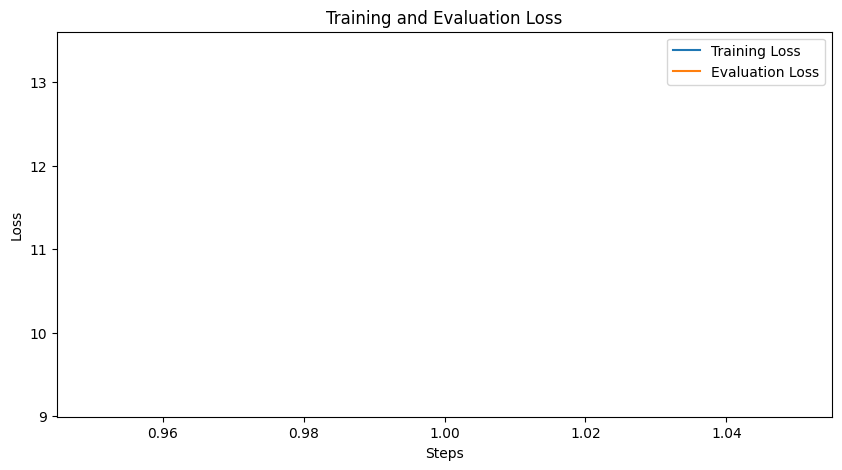

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history.epochs, loss_history.train_loss, label="Training Loss")
plt.plot(loss_history.epochs, loss_history.eval_loss, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss")

plt.savefig("./eval/train_val_loss.png")
plt.show()
plt.clf()

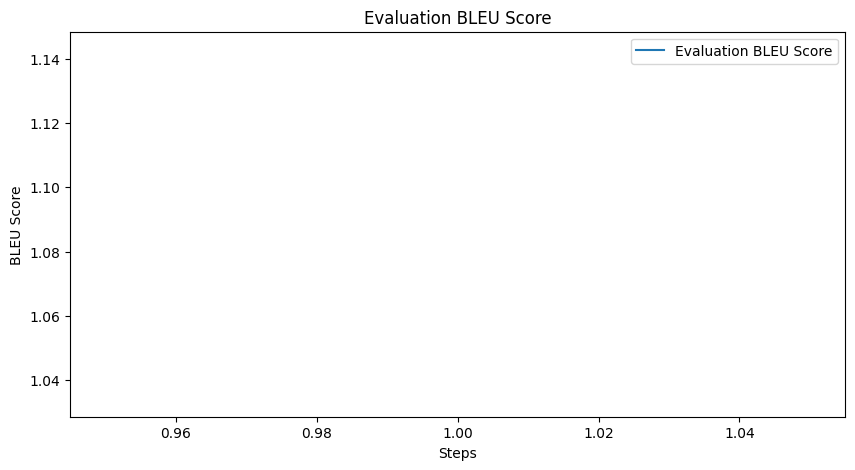

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history.epochs, loss_history.eval_bleu, label="Evaluation BLEU Score")
plt.xlabel("Steps")
plt.ylabel("BLEU Score")
plt.legend()
plt.title("Evaluation BLEU Score")

plt.savefig("./eval/val_bleu.png")
plt.show()

plt.clf()

In [ ]:
predictions, labels, metrics = trainer.predict(hf_test_tokenized)

In [ ]:
data_dict = compute_metrics((predictions, labels))

In [ ]:
data_dict_new = trainer.evaluate()
for key, item in data_dict_new.items():
    data_dict[key] = item

with open("./eval/final_eval.json", "w") as file:
    json.dump(data_dict, file)

data_dict

# Inference

In [ ]:
text = "This sucks ass"

In [ ]:
from transformers import pipeline

model_name = "stevhliu/my_awesome_model"

def inference_from_pipeline(text, model_name):
    classifier = pipeline("translation_en_to_vi", model=model_name)
    return classifier(text)

def inference_directly(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")

    # Ensure the inputs are on the correct device
    inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}

    # Generate predictions
    with torch.no_grad():
        outputs = trainer.model.generate(**inputs)
        logits = outputs.logits

    decoded_preds = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_preds

In [ ]:
inference_directly(text)